<h1 align=center>Build a Classification Model With the Titanic Dataset</h1>

## Description
In this exercise, we will carry out a classification using the [Titanic](https://www.kaggle.com/c/titanic) (the train subset) dataset from Kaggle.

The following is a description of the features in the data:

* **survival :** Survival (0 = No, 1 = Yes)
* **pclass :**	Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
* **sex :**	Sex	 
* **Age :**	Age in years	 
* **sibsp :**	# of siblings / spouses aboard the Titanic	 
* **parch :**	# of parents / children aboard the Titanic	 
* **ticket :**	Ticket number	 
* **fare :** Passenger fare	 
* **cabin :**	Cabin number	 
* **embarked :**	Port of Embarkation	(C = Cherbourg, Q = Queenstown, S = Southampton)

The file `titanic_clean.csv` contains data that has already been cleaned up as follows:

* Nulls in Age have been imputed with the mean age.
* The first letter of the cabin has been split to provide a new deck feature. This has then been one-hot encoded, with nulls going to a column Deck_nan.
* Sex has been one-hot encoded.
* Embarked has been one-hot encoded, with nulls going to a column Embarked_nan.

## Import required libraries and functionalities

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn functionality
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
def correlationMatrix(df):
    '''Show a correlation matrix for all features.'''
    columns = df.select_dtypes(include=['float64','int64']).columns
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none',cmap='RdYlBu')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation = 90)
    ax.set_yticklabels(columns)
    plt.show()
    
def decisionTreeSummary(model, column_names):
    '''Show a summary of the trained decision tree model'''
    # Plot the feature importances as bars
    fig = plt.figure(figsize=(8,len(column_names)/3))
    fig.suptitle('Decision tree feature importance', fontsize=16)
    rects = plt.barh(column_names, model.feature_importances_,color="khaki")
    # Annotate the bars with the feature importance values
    for rect in rects:
        width = round(rect.get_width(),4)
        plt.gca().annotate('  {}  '.format(width),
                    xy=(width, rect.get_y()),
                    xytext=(0,2),  
                    textcoords="offset points",  
                    ha='left', va='bottom')    
    plt.show()

def logisticRegressionSummary(model, column_names):
    '''Show a summary of the trained logistic regression model'''
    # Get a list of class names
    numclasses = len(model.classes_)
    if len(model.classes_)==2:
        classes =  [model.classes_[1]] # if we have 2 classes, sklearn only shows one set of coefficients
    else:
        classes = model.classes_
    # Create a plot for each class
    for i,c in enumerate(classes):
        # Plot the coefficients as bars
        fig = plt.figure(figsize=(8,len(column_names)/3))
        fig.suptitle('Logistic Regression Coefficients for Class ' + str(c), fontsize=16)
        rects = plt.barh(column_names, model.coef_[i],color="lightblue")
        # Annotate the bars with the coefficient values
        for rect in rects:
            width = round(rect.get_width(),4)
            plt.gca().annotate('  {}  '.format(width),
                        xy=(0, rect.get_y()),
                        xytext=(0,2),  
                        textcoords="offset points",  
                        ha='left' if width<0 else 'right', va='bottom')        
        plt.show()

# Define the task
Predict which passengers on the Titanic survive and comment on the features that best predict survival.

# Load the data
Load our clean data from titanic_clean.csv.

In [3]:
df = pd.read_csv('./Datasets/titanic_clean.csv')

## Inspect the data
Describe the shape (rows and columns) of the data:

In [4]:
df.shape

(891, 21)

Show the first 5 rows of the data:

In [5]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Embarked_nan,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan
0,0,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Show the data types of each column:

In [6]:
df.dtypes

Survived          int64
Pclass            int64
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Sex_female        int64
Sex_male          int64
Embarked_C        int64
Embarked_Q        int64
Embarked_S        int64
Embarked_nan      int64
Deck_A            int64
Deck_B            int64
Deck_C            int64
Deck_D            int64
Deck_E            int64
Deck_F            int64
Deck_G            int64
Deck_T            int64
Deck_nan          int64
dtype: object

Check for nulls in any column:

In [7]:
df.isnull().mean()

Survived        0.0
Pclass          0.0
Age             0.0
SibSp           0.0
Parch           0.0
Fare            0.0
Sex_female      0.0
Sex_male        0.0
Embarked_C      0.0
Embarked_Q      0.0
Embarked_S      0.0
Embarked_nan    0.0
Deck_A          0.0
Deck_B          0.0
Deck_C          0.0
Deck_D          0.0
Deck_E          0.0
Deck_F          0.0
Deck_G          0.0
Deck_T          0.0
Deck_nan        0.0
dtype: float64

## Understand the data

### Compute descriptive stats

In [8]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Embarked_nan,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413,0.647587,0.188552,0.086420,...,0.002245,0.016835,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.001122,0.771044
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,0.477990,0.477990,0.391372,0.281141,...,0.047351,0.128725,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.033501,0.420397
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Visualise
Show a correlation matrix plot (use the correlationMatrix() function).

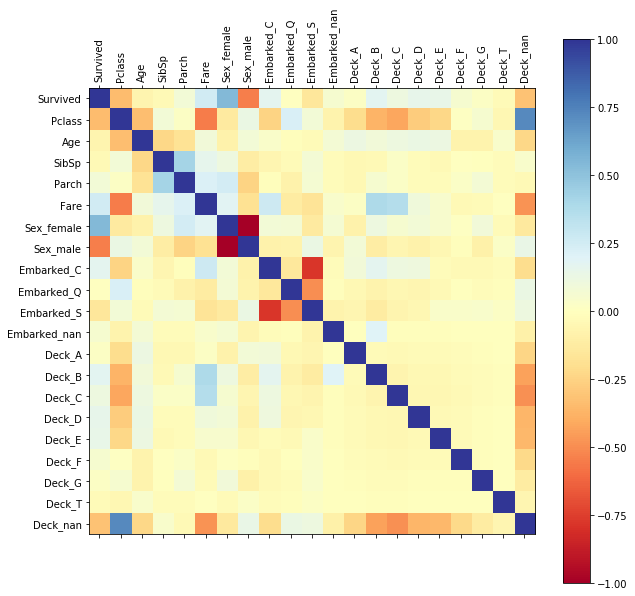

In [9]:
correlationMatrix(df)

*Looking at the matrix row for Survived, we can see from their colors that Sex (male and female) and Pclass show some correlation to Survived. Age and Sibsp are yellow and have little correlation to Survived.*

## Prepare Data

### Select features and split into input and target features
Split the features into X (the input features) and y (the target feature).

In [10]:
y = df['Survived']
X = df.drop(['Survived'], axis=1)

###  Scale features
Use the MinMaxScaler to scale the X features.  Confirm the scaling using the describe() function.

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
X.describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.654321,0.367921,0.065376,0.063599,0.062858,0.352413,0.647587,0.188552,0.086420,0.722783,0.002245,0.016835,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.001122,0.771044
std,0.418036,0.163383,0.137843,0.134343,0.096995,0.477990,0.477990,0.391372,0.281141,0.447876,0.047351,0.128725,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.033501,0.420397
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.271174,0.000000,0.000000,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.367921,0.000000,0.000000,0.028213,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.434531,0.125000,0.000000,0.060508,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*The MinMaxScaler scales all features such that the minimum value is 0 and the maximum is 1. The mean will vary according to the spread of the data.*

## Build Models

### Split into test and training sets
Split the X and y data into training and test sets.  Use a seed of 27 and 33% for the test sample size

In [12]:
test_size = 0.33
seed = 27
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### Create multiple models, fit them and check them
Create and fit a decision tree classifier.

In [13]:
dt_model = DecisionTreeClassifier().fit(X_train, y_train)

Create and fit a logistic regression classifier.

In [14]:
lr_model = LogisticRegression().fit(X_train, y_train)

Check the decision trees model by computing its accuracy score using the **training** data.

In [15]:
y_train_pred = dt_model.predict(X_train)
print('Decision Tree Accuracy Score = {:.3f}%'.format(100*accuracy_score(y_train, y_train_pred)))

Decision Tree Accuracy Score = 98.826%


Check the logistic regression model by computing its accuracy score using the **training** data.

In [16]:
y_train_pred = lr_model.predict(X_train)
print('Logistic Regression Accuracy Score = {:.3f}%'.format(100*accuracy_score(y_train, y_train_pred)))

Logistic Regression Accuracy Score = 80.201%


> *From the accuraccy scores, both models are reliable. Although the decision tree model performs much better than the logistic regression model, this is still just the training data used to build the models. Final judgment is reserved until we have the results of testing using the test data.*

## Evaluate the models
Compute the accuracy score for the decision trees model using the **test** data.

In [17]:
yhat = dt_model.predict(X_test)
print('Decision Tree Accuracy Score = {:.3f}%'.format(100*accuracy_score(y_test, yhat)))

Decision Tree Accuracy Score = 76.610%


Compute the accuracy score for the logistic regression model using the **test** data.

In [18]:
yhat = lr_model.predict(X_test)
print('Logistic Regression Accuracy Score = {:.3f}%'.format(100*accuracy_score(y_test, yhat)))

Logistic Regression Accuracy Score = 79.322%


> *Tables have been turned. Using the test data, our logistic regression model is now the best performing model.*

### Choose the best performing model

In [19]:
model = lr_model

*After evaluating the models and choosing the best one, a good step would be going back and review our process to see if we can make any improvements.*

## Inspect the models
Inspect the logistic regression model using the logisticRegressionSummary() function.

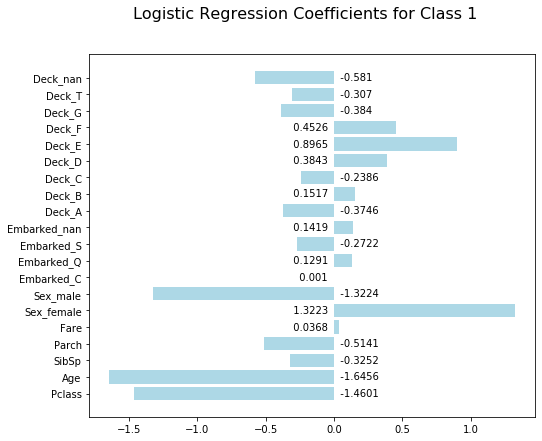

In [20]:
logisticRegressionSummary(lr_model, X.columns)

*We can conclude that :*
* *Age is the most important factor, and as the passanger's age increases, the most likely he will not survive.*
* *The second important factor is Pclass. Since the possible values for this feature are 1, 2 and 3 (ranks for classes), The strong negative coefficient suggests that the higher the value of Pclass, the less likely the passenger will survive.*
* *Sex is also an important factor for this model. The coefficients for the sex male and sex female features indicates that females are most likely to survive than men.*

Inspect the decision trees model using the decisionTreesSummary() function in functions.py.

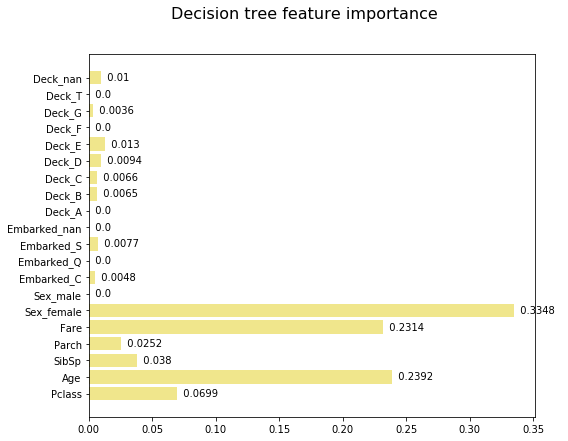

In [21]:
decisionTreeSummary(dt_model, X.columns)

*The feature importance factors in a decision tree only tell the overall degree to which the feature is used in constructing the decision tree.
From the above plot, we could say that Sex female, age and Pclass were the more important to the decision tree algorithm.*